## Using first 7 days preprocessed actigraphy data

In [71]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
from matplotlib.dates import WeekdayLocator
import plotly.express as px
import seaborn as sns

from math import ceil
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics, svm, manifold
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

## Load data

In [2]:
actdf = pd.read_csv('/Users/mcmahonmc/Github/machine-learning-2021/final_project/actigraphy_data_24hrday_df.csv')
print('actigraphy df')
print(actdf.shape)

targets = pd.read_csv('/Users/mcmahonmc/Github/machine-learning-2021/final_project/target_data.csv')
targets = targets.set_index('subject')
targets['edge_mean'] = targets[[x for x in targets.columns if x.startswith('edge_')]].mean(axis=1)
print('targets')
print(targets.shape)

targets[:5]

actigraphy df
(169, 125)
targets
(116, 270)


,Unnamed: 0,Unnamed: 0.1,age,group,gender,trails_b_z_score_x,trails_b_group,duration_mean_active,duration_mean_daily,duration_mean_rest,...,pc_dmn_fpn_18,pc_dmn_fpn_20,pc_dmn_fpn_mean,pc_dmn_mean,pc_fpn_mean,edge_0,edge_1,edge_2,edge_3,acc_mean_test_log
subject,,,,,,,,,,,,,,,,,,,,,
30004,0,0,27,Young Adults,2,-0.673139,Low,937.071429,1263.428571,436.428571,...,0.205587,0.218853,0.178769,0.585333,0.755358,0.451471,0.509899,0.257227,0.688757,-0.028171
30008,1,1,18,Young Adults,2,-0.869188,Low,872.928571,1251.214286,501.857143,...,0.206955,0.218107,0.194311,0.586016,0.720762,0.425655,0.824386,1.032888,0.311497,-0.057158
30009,2,2,25,Young Adults,2,-0.834951,Low,981.214286,1317.000000,455.142857,...,0.211377,0.222053,0.192073,0.482981,0.814453,0.508419,0.634550,0.578941,0.278736,-0.028171
30012,3,3,30,Young Adults,1,-0.268608,Medium,914.857143,1288.571429,465.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.216223
30015,4,4,26,Young Adults,1,-1.563107,Low,899.857143,1438.714286,452.000000,...,0.261610,0.277564,0.237269,0.651844,0.738657,0.264530,0.418911,0.402329,0.096133,-0.117783


In [4]:
x = StandardScaler().fit_transform(actdf.T.values) # normalizing the features

<AxesSubplot:>

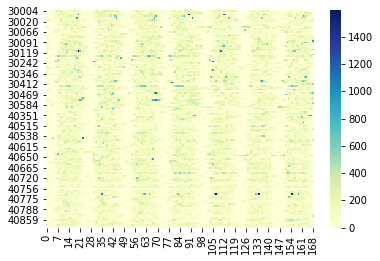

In [5]:
sns.heatmap(actdf.T, cmap="YlGnBu")

<AxesSubplot:>

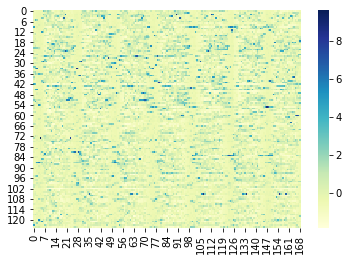

In [6]:
sns.heatmap(x, cmap="YlGnBu")

<AxesSubplot:>

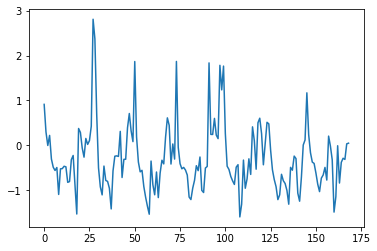

In [7]:
sns.lineplot(x=range(0,len(x[100])), y=x[100])

In [8]:
drop_subs = [ subject for subject in actdf.columns if int(subject) not in targets.index.values ]
drop_subs_idx = [ actdf.columns.get_loc(subject) for subject in actdf.columns if int(subject) not in targets.index.values ]

actdf = actdf.drop(drop_subs, axis=1)[:-3]
x = np.delete(x, drop_subs_idx, axis=0)

print(actdf.shape)
print(x.shape)

(166, 116)
(116, 169)


In [11]:
np.mean(x),np.std(x)

(0.019445063246755896, 1.008727551670545)

## Load standard rest-activity measures


In [13]:
rar = pd.read_csv('/Users/mcmahonmc/Github/machine-learning-2021/final_project/rar_df.csv', index_col=0)

drop_subs = [ int(subject) for subject in rar.index if str(subject) not in actdf.columns.values ]
drop_subs

rar2 = (rar[~rar.index.isin(drop_subs)])
print(rar2.shape)

(116, 8)


In [14]:
[col for col in targets.columns if 'mean_active' in col]

['duration_mean_active', 'total_ac_mean_active', 'sleep_time_mean_active']

In [15]:
[col for col in targets.columns if 'mean_sleep' in col]

['duration_mean_sleep',
 'total_ac_mean_sleep',
 'onset_latency_mean_sleep',
 'efficiency_mean_sleep',
 'sleep_time_mean_sleep']

<AxesSubplot:>

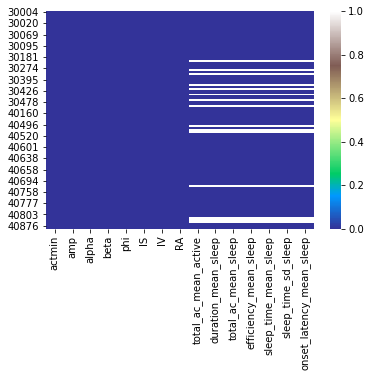

In [16]:
rar2 = rar2.merge(targets[['total_ac_mean_active',
                    'duration_mean_sleep', 
                    'total_ac_mean_sleep', 
                   'efficiency_mean_sleep',
                   'sleep_time_mean_sleep',
                   'sleep_time_sd_sleep',
                   'onset_latency_mean_sleep']],
          left_index=True, right_index=True)

sns.heatmap(rar2.isnull(), cmap='terrain')

### Define targets

target data uses output from rar dataframe merged with other variables of interest

**Missing data**

Missing data here for CESD (this is intended for young adults only), GDS (this is intended for older adults only), and some of the MRI measures (due to poor image quality).

For targets of interest, will impute missing values with the mean.

<AxesSubplot:ylabel='subject'>

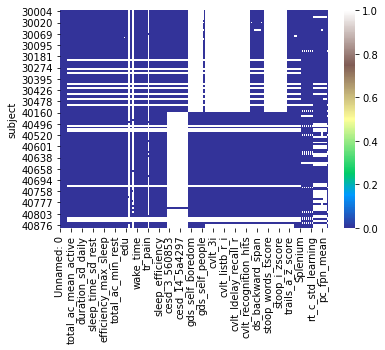

In [18]:
sns.heatmap(targets.isnull(), cmap='terrain')

In [19]:
# targets.to_csv('/Users/mcmahonmc/Github/machine-learning-2021/final/target_data.csv', index=True)

# Dimensionality Reduction

## PCA

[19.18457852 15.79408331 11.18625649  6.92342322  5.21604322  5.01750061
  4.69707758  4.16551688]


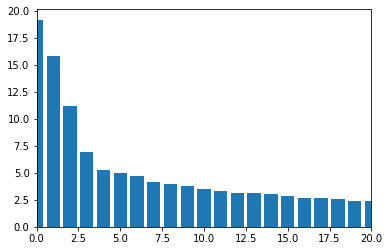

In [83]:
pca = PCA()
data_pcs = pca.fit_transform(x)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlim(0,20)
print(pca.explained_variance_[:8])

In [117]:
components_n = 3

In [118]:
pca = PCA(n_components=components_n)

# X: Xarray-like of shape (n_samples, n_features)
pca.fit(x)
manifold_2Da_pca = pca.fit_transform(x)
manifold_2D_pca = pd.DataFrame(manifold_2Da_pca, 
                               columns=['Component %s' % (i+1) for i in range(0, len(manifold_2Da_pca[0]))])

# Left with 2 dimensions
print(manifold_2D_pca.shape)
manifold_2D_pca.head()

(116, 3)


,Component 1,Component 2,Component 3
0,2.137376,-1.572793,-0.956907
1,0.326526,1.260976,-1.313000
2,7.856534,-3.335166,0.139670
3,6.526808,-2.024638,-0.420652
4,1.403335,-2.933569,0.271169


In [119]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.11066002 0.09110305 0.06452429]


## Isomap

[Benalexkeen resource](https://benalexkeen.com/isomap-for-dimensionality-reduction-in-python/)

In [120]:
iso = manifold.Isomap(n_neighbors=6, n_components=components_n)
iso.fit(x)
manifold_2Da = iso.transform(x)
manifold_2D_iso = pd.DataFrame(manifold_2Da, 
                               columns=['Component %s' % (i+1) for i in range(0, len(manifold_2Da[0]))])


# Left with 2 dimensions
print(manifold_2D_iso.shape)
manifold_2D_iso.head()

(116, 3)


,Component 1,Component 2,Component 3
0,-8.501047,-1.084442,2.000760
1,1.250829,-6.560760,-3.342801
2,-23.116744,-3.462066,8.961532
3,-12.437812,-7.661717,-9.081858
4,-6.425703,5.343720,-3.736651


## LLE

In [121]:
lle = manifold.LocallyLinearEmbedding(n_neighbors=6, n_components=components_n)
lle.fit(x)
manifold_2Da_lle = lle.transform(x)
manifold_2D_lle = pd.DataFrame(manifold_2Da, 
                               columns=['Component %s' % (i+1) for i in range(0, len(manifold_2Da[0]))])



# Left with 2 dimensions
print(manifold_2D_lle.shape)
manifold_2D_lle.head()

(116, 3)


,Component 1,Component 2,Component 3
0,-8.501047,-1.084442,2.000760
1,1.250829,-6.560760,-3.342801
2,-23.116744,-3.462066,8.961532
3,-12.437812,-7.661717,-9.081858
4,-6.425703,5.343720,-3.736651


# Comparison with traditional sleep and rest-activity measures

## PCA

Component 1 - total activity <br>
Component 2 - acrophase (phi)

<AxesSubplot:>

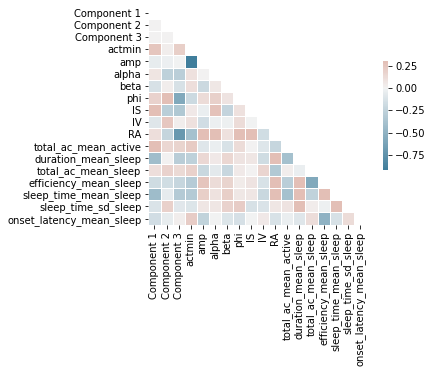

In [207]:
corr = manifold_2D_pca.join(rar2.reset_index().drop('index', axis=1)).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:>

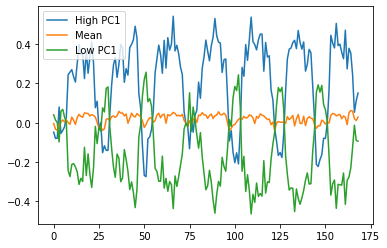

In [144]:
comp1_high_idx, comp1_low_idx = [np.where(manifold_2D_pca['Component 1'] > manifold_2D_pca['Component 1'].median()),
                 np.where(manifold_2D_pca['Component 1'] < manifold_2D_pca['Component 1'].median())]

sns.lineplot(x=range(0,len(x[0])), y=x[comp1_high_idx].mean(axis=0), label='High PC1')
sns.lineplot(x=range(0,len(x[0])), y=x.mean(axis=0), label='Mean')
sns.lineplot(x=range(0,len(x[0])), y=x[comp1_low_idx].mean(axis=0), label='Low PC1')

<AxesSubplot:>

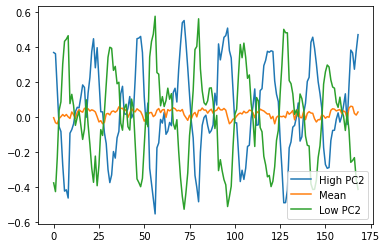

In [145]:
comp2_high_idx, comp2_low_idx = [np.where(manifold_2D_pca['Component 2'] > manifold_2D_pca['Component 2'].median()),
                 np.where(manifold_2D_pca['Component 2'] < manifold_2D_pca['Component 2'].median())]

sns.lineplot(x=range(0,len(x[0])), y=x[comp2_high_idx].mean(axis=0), label='High PC2')
sns.lineplot(x=range(0,len(x[0])), y=x.mean(axis=0), label='Mean')
sns.lineplot(x=range(0,len(x[0])), y=x[comp2_low_idx].mean(axis=0), label='Low PC2')

<AxesSubplot:>

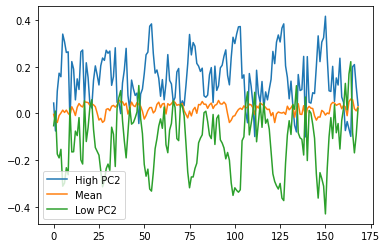

In [146]:
comp3_high_idx, comp3_low_idx = [np.where(manifold_2D_pca['Component 3'] > manifold_2D_pca['Component 3'].median()),
                 np.where(manifold_2D_pca['Component 3'] < manifold_2D_pca['Component 3'].median())]

sns.lineplot(x=range(0,len(x[0])), y=x[comp3_high_idx].mean(axis=0), label='High PC2')
sns.lineplot(x=range(0,len(x[0])), y=x.mean(axis=0), label='Mean')
sns.lineplot(x=range(0,len(x[0])), y=x[comp3_low_idx].mean(axis=0), label='Low PC2')

## Isomap

Isomap uses the above principle to create a similarity matrix for eigenvalue decomposition. Unlike other non-linear dimensionality reduction like LLE & LPP which only use local information, isomap uses the local information to create a global similarity matrix. The isomap algorithm uses euclidean metrics to prepare the neighborhood graph. Then, it approximates the geodesic distance between two points by measuring shortest path between these points using graph distance. Thus, it approximates both global as well as the local structure of the dataset in the low dimensional embedding. -[Paperspace Blog](https://blog.paperspace.com/dimension-reduction-with-isomap/)

Component 2 - phi

<AxesSubplot:>

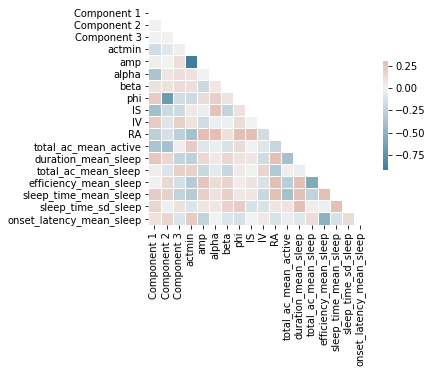

In [208]:
corr = manifold_2D_iso.join(rar2.reset_index().drop('index', axis=1)).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:>

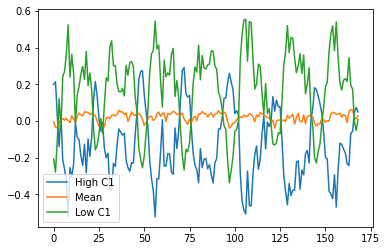

In [147]:
comp1_high_idx, comp1_low_idx = [np.where(manifold_2D_iso['Component 1'] > manifold_2D_iso['Component 1'].median()),
                 np.where(manifold_2D_iso['Component 1'] < manifold_2D_iso['Component 1'].median())]

sns.lineplot(x=range(0,len(x[0])), y=x[comp1_high_idx].mean(axis=0), label='High C1')
sns.lineplot(x=range(0,len(x[0])), y=x.mean(axis=0), label='Mean')
sns.lineplot(x=range(0,len(x[0])), y=x[comp1_low_idx].mean(axis=0), label='Low C1')

<AxesSubplot:>

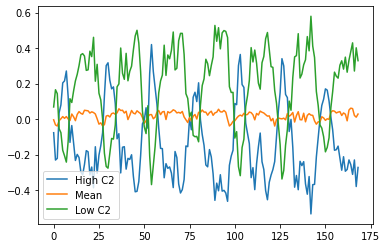

In [148]:
comp2_high_idx, comp2_low_idx = [np.where(manifold_2D_iso['Component 2'] > manifold_2D_iso['Component 2'].median()),
                 np.where(manifold_2D_iso['Component 2'] < manifold_2D_iso['Component 2'].median())]

sns.lineplot(x=range(0,len(x[0])), y=x[comp2_high_idx].mean(axis=0), label='High C2')
sns.lineplot(x=range(0,len(x[0])), y=x.mean(axis=0), label='Mean')
sns.lineplot(x=range(0,len(x[0])), y=x[comp2_low_idx].mean(axis=0), label='Low C2')

<AxesSubplot:>

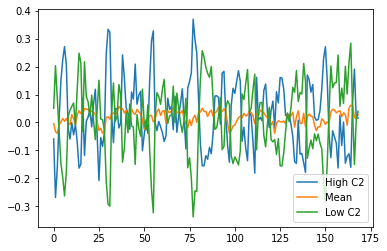

In [149]:
comp3_high_idx, comp3_low_idx = [np.where(manifold_2D_iso['Component 3'] > manifold_2D_iso['Component 3'].median()),
                 np.where(manifold_2D_iso['Component 3'] < manifold_2D_iso['Component 3'].median())]

sns.lineplot(x=range(0,len(x[0])), y=x[comp3_high_idx].mean(axis=0), label='High C2')
sns.lineplot(x=range(0,len(x[0])), y=x.mean(axis=0), label='Mean')
sns.lineplot(x=range(0,len(x[0])), y=x[comp3_low_idx].mean(axis=0), label='Low C2')

## LLE

Component 2 - phi

<AxesSubplot:>

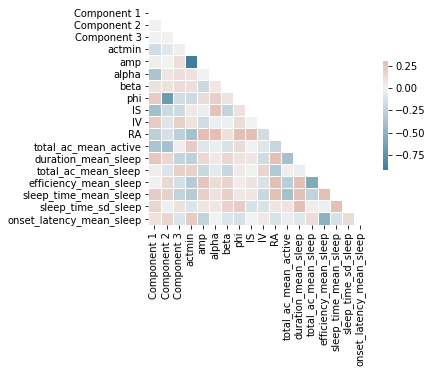

In [214]:
corr = manifold_2D_lle.join(rar2.reset_index().drop('index', axis=1)).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:>

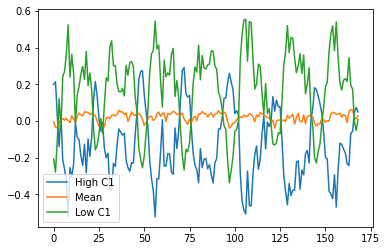

In [150]:
comp1_high_idx, comp1_low_idx = [np.where(manifold_2D_lle['Component 1'] > manifold_2D_lle['Component 1'].median()),
                 np.where(manifold_2D_lle['Component 1'] < manifold_2D_lle['Component 1'].median())]

sns.lineplot(x=range(0,len(x[0])), y=x[comp1_high_idx].mean(axis=0), label='High C1')
sns.lineplot(x=range(0,len(x[0])), y=x.mean(axis=0), label='Mean')
sns.lineplot(x=range(0,len(x[0])), y=x[comp1_low_idx].mean(axis=0), label='Low C1')

<AxesSubplot:>

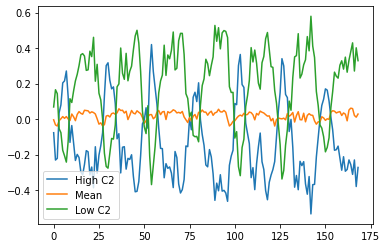

In [151]:
comp2_high_idx, comp2_low_idx = [np.where(manifold_2D_lle['Component 2'] > manifold_2D_lle['Component 2'].median()),
                 np.where(manifold_2D_lle['Component 2'] < manifold_2D_lle['Component 2'].median())]

sns.lineplot(x=range(0,len(x[0])), y=x[comp2_high_idx].mean(axis=0), label='High C2')
sns.lineplot(x=range(0,len(x[0])), y=x.mean(axis=0), label='Mean')
sns.lineplot(x=range(0,len(x[0])), y=x[comp2_low_idx].mean(axis=0), label='Low C2')

<AxesSubplot:>

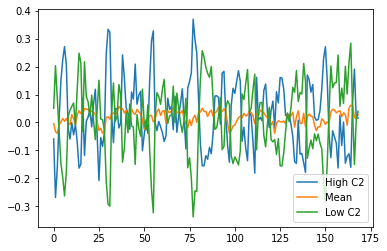

In [152]:
comp3_high_idx, comp3_low_idx = [np.where(manifold_2D_lle['Component 3'] > manifold_2D_lle['Component 3'].median()),
                 np.where(manifold_2D_lle['Component 3'] < manifold_2D_lle['Component 3'].median())]

sns.lineplot(x=range(0,len(x[0])), y=x[comp3_high_idx].mean(axis=0), label='High C2')
sns.lineplot(x=range(0,len(x[0])), y=x.mean(axis=0), label='Mean')
sns.lineplot(x=range(0,len(x[0])), y=x[comp3_low_idx].mean(axis=0), label='Low C2')

## Correlations

MAE: Average absolute error between the model prediction and the actual observed data. <br>
RMSE: Lower the RMSE, the more closely a model is able to predict the actual observations.

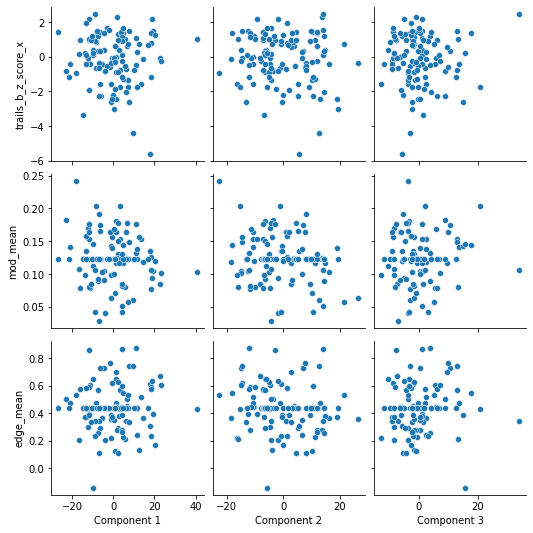

In [197]:
sns.pairplot(data=manifold_2D_iso.join(targets[['trails_b_z_score_x', 'mod_mean', 'edge_mean']].reset_index()), 
             x_vars = [col for col in manifold_2D_iso.columns if col.startswith('Component')],
            y_vars = ['trails_b_z_score_x', 'mod_mean', 'edge_mean'])

In [195]:
#define cross-validation method to use
cv = LeaveOneOut()

#build multiple linear regression model
model = LinearRegression()

#trails b
scores = cross_val_score(model, manifold_2D_iso, targets['trails_b_z_score_x'], 
                         scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

print('Trails B, MAE: %.2f, RMSE: %.2f' % (np.mean(np.absolute(scores)), np.sqrt(np.mean(np.absolute(scores)))))


#modularity
scores = cross_val_score(model, manifold_2D_iso, targets['mod_mean'], 
                         scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

print('Modularity, MAE: %.2f, RMSE: %.2f' % (np.mean(np.absolute(scores)), np.sqrt(np.mean(np.absolute(scores)))))

      
#edge strength
scores = cross_val_score(model, manifold_2D_iso, targets['edge_mean'], 
                         scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)


print('Edge Strength, MAE: %.2f, RMSE: %.2f' % (np.mean(np.absolute(scores)), np.sqrt(np.mean(np.absolute(scores)))))


Trails B, MAE: 1.17, RMSE: 1.08
Modularity, MAE: 0.03, RMSE: 0.16
Edge Strength, MAE: 0.12, RMSE: 0.34


# Classification 

## SVM

[Datacamp](https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python)

### Cognition

In [153]:
targets.columns

Index(['subject', 'Unnamed: 0', 'Unnamed: 0.1', 'age', 'group', 'gender',
       'trails_b_z_score_x', 'trails_b_group', 'duration_mean_active',
       'duration_mean_daily',
       ...
       'edge_0', 'edge_1', 'edge_2', 'edge_3', 'acc_mean_test_log',
       'mod_mean_scaled', 'mod_mean_group', 'edge_mean', 'edge_mean_scaled',
       'edge_mean_group'],
      dtype='object', length=276)

In [162]:
targets = targets.reset_index()

targets['trails_b_group'] = np.where(targets['trails_b_z_score_x'] > 1, "High", "Average")
targets['trails_b_group'] = np.where(targets['trails_b_z_score_x'] < -1, "Low", targets['trails_b_group'])

average_idx = targets[targets['trails_b_group'] == 'Average'].index.values

In [156]:
print('PCA Silhouette score: %.3f' % metrics.silhouette_score(manifold_2D_pca, targets['trails_b_group'], metric='euclidean'))
print('Isomap Silhouette score: %.3f' % metrics.silhouette_score(manifold_2D_iso, targets['trails_b_group'], metric='euclidean'))
print('LLE Silhouette score: %.3f' % metrics.silhouette_score(manifold_2D_lle, targets['trails_b_group'], metric='euclidean'))

silscore = pd.DataFrame({'method': ['PCA', 'Isomap', 'LLE'],
                        'silscore': [metrics.silhouette_score(manifold_2D_pca, targets['trails_b_group'], metric='euclidean'),
                                    metrics.silhouette_score(manifold_2D_iso, targets['trails_b_group'], metric='euclidean'),
                                    metrics.silhouette_score(manifold_2D_lle, targets['trails_b_group'], metric='euclidean')]})


print('\n\n%s' % silscore.min())

PCA Silhouette score: -0.025
Isomap Silhouette score: -0.032
LLE Silhouette score: -0.032


method        Isomap
silscore   -0.032012
dtype: object


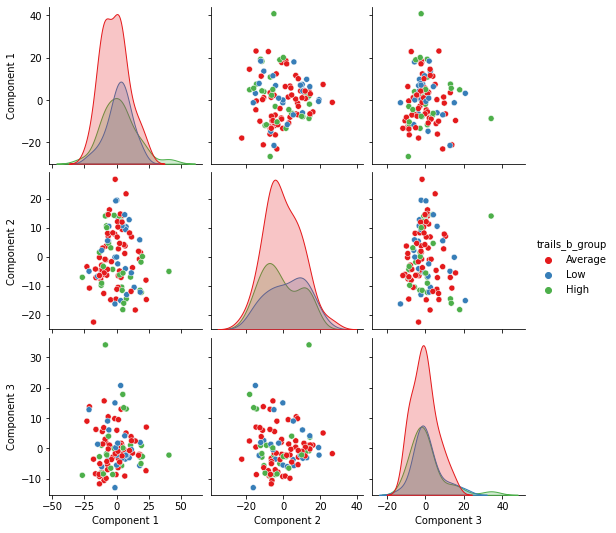

In [171]:
sns.pairplot(manifold_2D_iso.join(targets['trails_b_group'].reset_index()), 
             hue = 'trails_b_group', palette='Set1',
             x_vars = [col for col in manifold_2D_lle.columns if col.startswith('Component')],
             y_vars = [col for col in manifold_2D_lle.columns if col.startswith('Component')])

:::{note}
The Silhouette score measures the separability between clusters based on the distances between and within clusters. It calculates the mean intra-cluster distance (a), which is the mean distance within a cluster, and the mean nearest-cluster distance (b), which is the distance between a sample and the nearest cluster it is not a part of, for each sample. Then, the Silhouette coefficient for a sample is (b - a) / max(a, b). - [Maarten Grootendorst](https://www.maartengrootendorst.com/blog/customer/)
:::

Isomap yields the lowest silhouette score, suggesting that this dimensionality reduction technique as implemented with the selected parameters outperformed PCA and LLE techniques in terms of cluster separability based on Trails B performance ('high', 'average', 'low').

In [166]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(manifold_2D_iso.drop(index=average_idx), 
                                                    targets['trails_b_group'][targets['trails_b_group'] != 'Average'], 
                                                    test_size=0.3, random_state=100) 

print('Training data points: dim_x = %s, dim_y = %s' % (X_train.shape, y_train.shape))
print('Test data points: dim_x = %s, dim_y = %s' % (X_test.shape, y_test.shape))

Training data points: dim_x = (38, 3), dim_y = (38,)
Test data points: dim_x = (17, 3), dim_y = (17,)


In [167]:
#Create a svm Classifier
kernel_methods = ['linear', 'poly', 'rbf', 'sigmoid']
accdf = pd.DataFrame()

for kernel_method in kernel_methods:
    
    clf = svm.SVC(kernel=kernel_method)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    
    acc = metrics.accuracy_score(y_test, y_pred)
    accdf = accdf.append({'method': kernel_method,
                      'accuracy': acc}, ignore_index=True)
    

    print(kernel_method + ", Accuracy: %.2f " % acc)
    

print('\n\n%s' % accdf.max())

linear, Accuracy: 0.65 
poly, Accuracy: 0.53 
rbf, Accuracy: 0.53 
sigmoid, Accuracy: 0.65 


method       sigmoid
accuracy    0.647059
dtype: object


In [168]:
clf = svm.SVC(kernel=accdf.max()['method'])

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [169]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision: %.2f" % metrics.precision_score(y_test, y_pred, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall: %.2f" % metrics.recall_score(y_test, y_pred, average='weighted'))

Precision: 0.65
Recall: 0.65


In [170]:
markers = y_pred + ', ' + y_test

px.scatter_3d(x=X_test['Component 1'], 
              y=X_test['Component 2'], 
              z=targets.iloc[y_test.index.values]['trails_b_z_score_x'],
              color=markers,
              labels = {
                  'x' : 'Component 1',
                  'y' : 'Component 2',
                  'z' : 'Trails B Z-Score',
                  'color': 'Predicted vs. True Performance'
              },
              title='Components and Trails B Z-Score')


### Brain

In [174]:
targets['mod_mean'].fillna(targets['mod_mean'].mean(), inplace=True)
print(targets['mod_mean'])
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
targets['mod_mean_scaled'] = scaler.fit_transform(targets['mod_mean'].values.reshape(-1,1))
targets['mod_mean_scaled'] 

targets['mod_mean_group'] = np.where(targets['mod_mean_scaled'] > 1, "High", "Average")
targets['mod_mean_group'] = np.where(targets['mod_mean_scaled'] < -1, "Low", targets['mod_mean_group'] )

average_idx = targets[targets['mod_mean_group'] == 'Average'].index.values


0      0.204444
1      0.180552
2      0.182655
3      0.123560
4      0.165057
         ...   
111    0.178232
112    0.123560
113    0.139451
114    0.123560
115    0.123560
Name: mod_mean, Length: 116, dtype: float64


In [51]:
print('PCA Silhouette score: %.3f' % metrics.silhouette_score(manifold_2D_pca, targets['mod_mean_group'], metric='euclidean'))
print('Isomap Silhouette score: %.3f' % metrics.silhouette_score(manifold_2D_iso, targets['mod_mean_group'], metric='euclidean'))
print('LLE Silhouette score: %.3f' % metrics.silhouette_score(manifold_2D_lle, targets['mod_mean_group'], metric='euclidean'))

silscore = pd.DataFrame({'method': ['PCA', 'Isomap', 'LLE'],
                        'silscore': [metrics.silhouette_score(manifold_2D_pca, targets['mod_mean_group'], metric='euclidean'),
                                    metrics.silhouette_score(manifold_2D_iso, targets['mod_mean_group'], metric='euclidean'),
                                    metrics.silhouette_score(manifold_2D_lle, targets['mod_mean_group'], metric='euclidean')]})


print('\n\n%s' % silscore.min())

PCA Silhouette score: -0.077
Isomap Silhouette score: -0.082
LLE Silhouette score: -0.113


method        Isomap
silscore   -0.113357
dtype: object


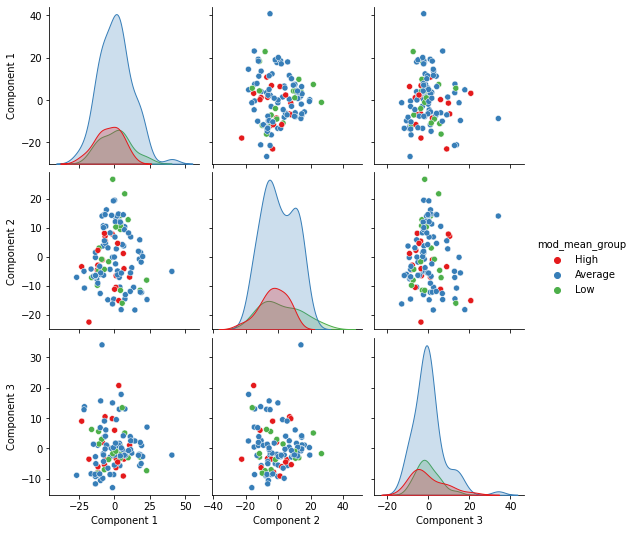

In [180]:
sns.pairplot(manifold_2D_iso.join(targets['mod_mean_group'].reset_index()), 
             hue = 'mod_mean_group', palette='Set1',
             x_vars = [col for col in manifold_2D_iso.columns if col.startswith('Component')],
             y_vars = [col for col in manifold_2D_iso.columns if col.startswith('Component')])

In [175]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(manifold_2D_iso.drop(index=average_idx),
                                                    targets['mod_mean_group'][targets['mod_mean_group'] != 'Average'], 
                                                    test_size=0.3, random_state=100) 

print('Training data points: dim_x = %s, dim_y = %s' % (X_train.shape, y_train.shape))
print('Test data points: dim_x = %s, dim_y = %s' % (X_test.shape, y_test.shape))

Training data points: dim_x = (25, 3), dim_y = (25,)
Test data points: dim_x = (11, 3), dim_y = (11,)


In [176]:
targets['mod_mean_group'].unique()

array(['High', 'Average', 'Low'], dtype=object)

In [177]:
#Create a svm Classifier
kernel_methods = ['linear', 'poly', 'rbf', 'sigmoid']
accdf = pd.DataFrame()

for kernel_method in kernel_methods:
    
    clf = svm.SVC(kernel=kernel_method)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    
    acc = metrics.accuracy_score(y_test, y_pred)
    accdf = accdf.append({'method': kernel_method,
                      'accuracy': acc}, ignore_index=True)
    

    print(kernel_method + ", Accuracy: %.2f " % acc)
    

print('\n\n%s' % accdf.max())

linear, Accuracy: 0.55 
poly, Accuracy: 0.64 
rbf, Accuracy: 0.55 
sigmoid, Accuracy: 0.36 


method       sigmoid
accuracy    0.636364
dtype: object


In [55]:
#Create a svm Classifier
# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
clf = svm.SVC(kernel=accdf.max()['method'])

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [56]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision: %.2f" % metrics.precision_score(y_test, y_pred, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall: %.2f" % metrics.recall_score(y_test, y_pred, average='weighted'))

Precision: 0.37
Recall: 0.36


In [57]:
markers = y_pred + ', ' + y_test

px.scatter_3d(x=X_test['Component 1'], 
              y=X_test['Component 2'], 
              z=targets.iloc[y_test.index.values]['mod_mean_group'],
              color=markers,
              labels = {
                  'x' : 'Component 1',
                  'y' : 'Component 2',
                  'z' : 'DMN-FPN Modularity',
                  'color': 'Predicted vs. Truth'
              },
              title='Components and DMN-FPN Modularity')



In [58]:
targets['edge_mean'] = targets[[x for x in targets.columns if x.startswith('edge_')]].mean(axis=1)

In [183]:
targets['edge_mean'].fillna(targets['edge_mean'].mean(), inplace=True)
print(targets['edge_mean'])
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
targets['edge_mean_scaled'] = scaler.fit_transform(targets['edge_mean'].values.reshape(-1,1))
targets['edge_mean_scaled'] 

targets['edge_mean_group'] = np.where(targets['edge_mean_scaled'] > 1, "High", "Average")
targets['edge_mean_group'] = np.where(targets['edge_mean_scaled'] < -1, "Low", targets['edge_mean_group'] )

average_idx = targets[targets['edge_mean_group'] == 'Average'].index.values

0      0.476839
1      0.648607
2      0.500161
3      0.438322
4      0.295476
         ...   
111    0.112614
112    0.438322
113    0.373898
114    0.438322
115    0.438322
Name: edge_mean, Length: 116, dtype: float64


In [60]:
print('PCA Silhouette score: %.3f' % metrics.silhouette_score(manifold_2D_pca, targets['edge_mean_group'], metric='euclidean'))
print('Isomap Silhouette score: %.3f' % metrics.silhouette_score(manifold_2D_iso, targets['edge_mean_group'], metric='euclidean'))
print('LLE Silhouette score: %.3f' % metrics.silhouette_score(manifold_2D_lle, targets['edge_mean_group'], metric='euclidean'))

silscore = pd.DataFrame({'method': ['PCA', 'Isomap', 'LLE'],
                        'silscore': [metrics.silhouette_score(manifold_2D_pca, targets['edge_mean_group'], metric='euclidean'),
                                    metrics.silhouette_score(manifold_2D_iso, targets['edge_mean_group'], metric='euclidean'),
                                    metrics.silhouette_score(manifold_2D_lle, targets['edge_mean_group'], metric='euclidean')]})


print('\n\n%s' % silscore.min())

PCA Silhouette score: -0.074
Isomap Silhouette score: -0.078
LLE Silhouette score: -0.051


method       Isomap
silscore   -0.07795
dtype: object


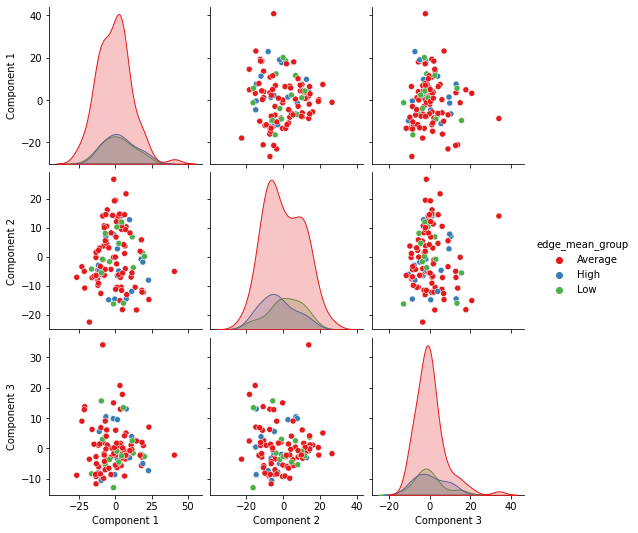

In [179]:
sns.pairplot(manifold_2D_lle.join(targets['edge_mean_group'].reset_index()), 
             hue = 'edge_mean_group', palette='Set1',
             x_vars = [col for col in manifold_2D_lle.columns if col.startswith('Component')],
             y_vars = [col for col in manifold_2D_lle.columns if col.startswith('Component')])

In [184]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(manifold_2D_iso.drop(index=average_idx),
                                                    targets['edge_mean_group'][targets['edge_mean_group'] != 'Average'], 
                                                    test_size=0.3, random_state=100) 

print('Training data points: dim_x = %s, dim_y = %s' % (X_train.shape, y_train.shape))
print('Test data points: dim_x = %s, dim_y = %s' % (X_test.shape, y_test.shape))

Training data points: dim_x = (23, 3), dim_y = (23,)
Test data points: dim_x = (10, 3), dim_y = (10,)


In [185]:
targets['edge_mean_group'].unique()

array(['Average', 'High', 'Low'], dtype=object)

In [186]:
#Create a svm Classifier
kernel_methods = ['linear', 'poly', 'rbf', 'sigmoid']
accdf = pd.DataFrame()

for kernel_method in kernel_methods:
    
    clf = svm.SVC(kernel=kernel_method)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    
    acc = metrics.accuracy_score(y_test, y_pred)
    accdf = accdf.append({'method': kernel_method,
                      'accuracy': acc}, ignore_index=True)
    

    print(kernel_method + ", Accuracy: %.2f " % acc)
    

print('\n\n%s' % accdf.max())

linear, Accuracy: 0.40 
poly, Accuracy: 0.50 
rbf, Accuracy: 0.60 
sigmoid, Accuracy: 0.60 


method      sigmoid
accuracy        0.6
dtype: object


In [187]:
#Create a svm Classifier
# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
clf = svm.SVC(kernel=accdf.max()['method'])

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [188]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision: %.2f" % metrics.precision_score(y_test, y_pred, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall: %.2f" % metrics.recall_score(y_test, y_pred, average='weighted'))

Precision: 0.65
Recall: 0.60


In [189]:
markers = y_pred + ', ' + y_test

px.scatter_3d(x=X_test['Component 1'], 
              y=X_test['Component 2'], 
              z=targets.iloc[y_test.index.values]['edge_mean_group'],
              color=markers,
              labels = {
                  'x' : 'Component 1',
                  'y' : 'Component 2',
                  'z' : 'Memory Network Edge Strength',
                  'color': 'Predicted vs. Truth'
              },
              title='Components and Memory Network Edge Strength')
